### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import numpy as np
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = collections.defaultdict(dict)

In [4]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [
                   ((0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0),(1,3)),
                   ((0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0),(4,1)),
                   ((0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0),(2,3)),
                   ((1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1),(1,4))]    
    for q_values in sample_q_values:
        state = q_values[0] 
        action = q_values[1]      
        States_track[state][action] = []  

In [5]:
initialise_tracking_states()

In [6]:
def save_tracking_states(state,action,rewards):
    if state in States_track.keys():
        if action in States_track[state].keys():
            print (state)
            print (States_track[state][action])
            print (rewards)
            States_track[state][action].append(rewards)

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # Tracking the loss
        self.track_loss=[]

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001 
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001

        self.batch_size = 32 

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(256, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(150, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,request_actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return "random", request_actions[random.randrange(len(request_actions))]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            print ('getAction')
            print (q_value)
            act = np.argmax(q_value[0])
            print (act)
            print (type(act))
            return "fixed",act   

    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s',done> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state,done_boolean = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # 4. Fit your model and track the loss values
            history=self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            self.track_loss.append(history.history['loss'])


    def get_model_weights(self):
        return self.model.get_weights()


In [9]:
Episodes=1000
env=CabDriver()
action_size=env.action_size
state_size=env.state_size
#Call the DQN agent
agent=DQNAgent(state_size=state_size,action_size=action_size)
rewards_per_episode, episodes = [], []

### DQN block

In [10]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
   
    terminal_state=False
    score=0  
    env_initalized=env.reset()
    state=env_initalized[2]
    # episode_lenght=-1
    while not terminal_state:
        # episode_lenght+=1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        request_actions=env.requests(state)[1]
        #print ("start")
        tex, next_action=agent.get_action(env.state_encod_arch1(state),request_actions)
        if tex == "fixed":
            print ("next_action ::" + str(next_action))
        
        # 2. Evaluate your reward and next state
        next_state,action,reward,is_done=env.next_state_func(tex, state,next_action,Time_matrix)
        if tex == "fixed":
            print (state)
            print ("next_action ::" + str(next_action))
            print ("action::" + str(action))
            print (reward)
            print (is_done)
            print ("end")
        key_state = tuple(env.state_encod_arch1(state))
        save_tracking_states(key_state,action,reward)
        if action[0]!=0:
            # 3. Append the experience to the memory
            agent.append_sample(env.state_encod_arch1(state),env.action_space.index(action),reward,env.state_encod_arch1(next_state),is_done)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            score+=reward
        # swapping state with next_state
        state=next_state
        terminal_state=is_done
    rewards_per_episode.append(score)
    episodes.append(episode)
    # print(episode_lenght)

    
    if agent.epsilon_max > agent.epsilon_min:
        agent.epsilon_max=agent.epsilon_min+(agent.epsilon_max-agent.epsilon_min)*np.exp(-0.000001*episode)
    
    
    if (episode+1) % 100 == 0:                
        save_obj(agent.get_model_weights(), 'weights_per_100_epiosde')
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon_max))
    
        

getAction
[[ 28.716183   0.         0.        17.227999 208.9951     0.
  219.51898  213.73074    0.       213.02296  211.11098  205.06837
    0.       210.95273  224.64777  224.56339  207.93588    0.
    0.       217.78871 ]]
14
<class 'numpy.int64'>
next_action ::14
start next_state_func ::14
14
end next_state_func
14
(3, 2)
(3, 14.0, 1)
next_action ::14
action::(3, 2)
12.0
False
end
getAction
[[ 32.94036    0.         0.        18.205284 243.02353    0.
  260.98828  246.98494    0.       251.63708  252.19452  235.4372
    0.       256.88715  263.2535   268.02283  247.62642    0.
    0.       256.4569  ]]
15
<class 'numpy.int64'>
next_action ::15
start next_state_func ::15
15
end next_state_func
15
(3, 4)
(3, 14.0, 6)
next_action ::15
action::(3, 4)
12.0
False
end
getAction
[[ 30.769442   0.         0.        14.84973  249.36478    0.
  254.6105   246.72467    0.       263.03363  262.76495  245.20932
    0.       247.87831  260.75256  261.93207  250.94858    0.
    0.       266.17017

getAction
[[ 99.778725  23.594173   0.         0.       473.7909   470.4595
  462.1951   468.6476     0.       472.03036  486.33844  485.47363
    0.       444.76218  462.05136  476.15906  458.6283     0.
    0.       507.878   ]]
19
<class 'numpy.int64'>
next_action ::19
start next_state_func ::19
19
end next_state_func
19
(4, 3)
(4, 19.0, 3)
next_action ::19
action::(4, 3)
24.0
False
end
getAction
[[ 96.6158    26.839687   0.         0.       488.7131   491.1815
  496.91223  484.18533    0.       511.10342  522.7559   500.02573
    0.       466.7705   478.8362   486.79187  482.1601     0.
    0.       516.61285 ]]
10
<class 'numpy.int64'>
next_action ::10
start next_state_func ::10
10
end next_state_func
10
(2, 3)
(4, 14.0, 6)
next_action ::10
action::(2, 3)
32.0
False
end
getAction
[[126.88072   19.591644   0.         8.345715 534.3604   556.02026
  565.801    558.1706     0.       514.70715  538.81714  533.98126
    0.       504.73843  538.37555  563.4369   539.2849     0.
    0.  

getAction
[[ 94.98749   11.532928   0.        18.211002 463.70526  465.6929
  445.91415  475.00647    0.       473.72418  461.94247  450.617
    0.       486.6416   502.82712  484.80182  463.90662    0.
  467.42776  474.5021  ]]
14
<class 'numpy.int64'>
next_action ::14
start next_state_func ::14
14
end next_state_func
14
(3, 2)
(3, 11.0, 4)
next_action ::14
action::(3, 2)
12.0
False
end
getAction
[[123.295715   9.589491   0.        35.63894  450.2274   474.48853
  492.08282  501.11148    0.       407.02493  450.55078  441.58353
    0.       462.59262  492.9384   488.44507  442.3265     0.
  498.6565   486.53796 ]]
7
<class 'numpy.int64'>
next_action ::7
start next_state_func ::7
7
end next_state_func
7
(1, 4)
(1, 6.0, 3)
next_action ::7
action::(1, 4)
24.0
False
end
getAction
[[ 73.16881    9.179362   0.         8.299836 422.46082  419.9448
  418.55765  411.0429     0.       447.22235  441.74475  422.31967
    0.       401.3614   423.7118   420.68994  415.3827     0.
  399.2977   414.

(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)
[-35.0, -35.0, -35.0, -35.0, -35.0]
-35.0
getAction
[[123.60713   22.370872   0.        23.857983 623.38745  667.21155
  643.37665  645.62225    0.       536.6904   581.4481   647.28
    0.       600.37103  640.9859   638.06995  616.98334    0.
  666.6056   665.3645  ]]
5
<class 'numpy.int64'>
next_action ::5
start next_state_func ::5
5
end next_state_func
5
(1, 2)
(4, 8.0, 1)
next_action ::5
action::(1, 2)
26.0
False
end
getAction
[[ 78.35974  24.91232   0.        0.      637.46405 616.1088  604.6316
  617.49725   0.      684.2092  663.0543  650.9866    0.      618.2991
  622.06433 631.32764 628.77246   0.      630.1958  622.74963]]
9
<class 'numpy.int64'>
next_action ::9
start next_state_func ::9
9
end next_state_func
9
(2, 1)
(2, 11.0, 5)
next_action ::9
action::(2, 1)
44.0
False
end
getAction
[[ 77.371506  23.988028   0.         0.       549.8358   562.97766
  545.88617  524

KeyboardInterrupt: 

In [ ]:
save_obj(rewards_per_episode,"rewards_"+str(Episodes))

In [ ]:
a = (0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0)
plt.plot(States_track[a][(2,3)])
plt.show()

In [24]:
for i in States_track.keys():
    for j in States_track[i].keys():
        print(len(States_track[i][j]))

19
16
12
8


### Tracking Convergence

In [18]:
#=============TODO:

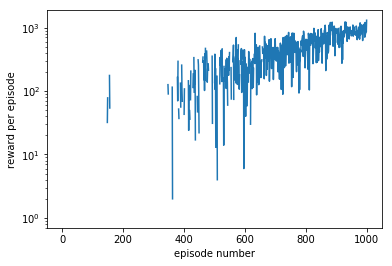

In [19]:
with open('rewards_'+str(Episodes)+'.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.yscale('log')
plt.show()

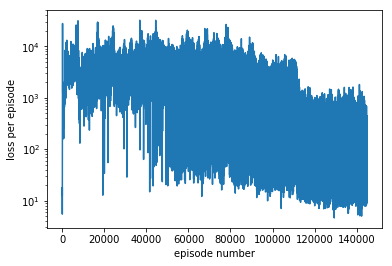

In [20]:
# Tracking loss

plt.plot(list(range(len(agent.track_loss))), agent.track_loss)
plt.xlabel("episode number")
plt.ylabel("loss per episode")
plt.yscale('log')
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [26]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

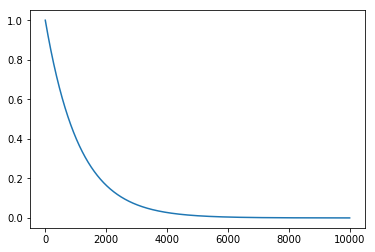

In [27]:
plt.plot(time, epsilon)
plt.show()

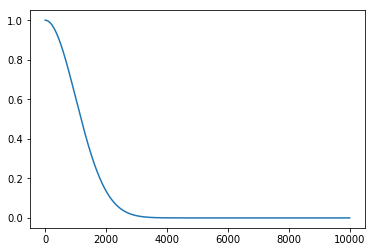

In [28]:
time = np.arange(0,10000)
epsilon_max = 1.0
epsilon_decay = 0.0003
epsilon_min = 0.00000001
epsilon = []
for i in range(0,10000):
    epsilon_max=epsilon_min+(epsilon_max-epsilon_min)*np.exp(-0.000001*i)
    epsilon.append(epsilon_max)  
plt.plot(time, epsilon)
plt.show() 